<a href="https://colab.research.google.com/github/anhduong77/Credit-Scoring-ML-project/blob/main/notebooks/2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project/data/model_data.csv', low_memory=False)

# Data quality

In [ ]:
df.shape

(1765426, 151)

## Data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765426 entries, 0 to 1765425
Columns: 151 entries, issue_d to settlement_term
dtypes: float64(113), int64(1), object(37)
memory usage: 2.0+ GB


- There are 151 columns with 113 float data types columns and 38 object data types columns

In [ ]:
data_description = pd.read_csv('/content/drive/MyDrive/project/data/data_dictionary.csv')

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data_description)

https://docs.google.com/spreadsheets/d/1nHVEswXK_a9Gtbuad4PwRApN5W0LxEiXZiLofmVHx5U/edit#gid=0


## Checking null and missing values

In [ ]:
# check for null and missing values
df_null = df.isnull().sum().to_frame()
df_null['missing_percentage'] = (df_null[0] / df.shape[0]) * 100
df_null.sort_values(by='missing_percentage', ascending=False, inplace=True)
print(df_null.head(10))
print("--------------------------------------")
print("Total features with missing values:", df_null[df_null[0] > 0].shape[0])
print("Total features with no missing values:", df_null[df_null[0] == 0].shape[0])

                                                  0  missing_percentage
member_id                                   1765426          100.000000
orig_projected_additional_accrued_interest  1757096           99.528159
hardship_reason                             1754877           99.402467
hardship_payoff_balance_amount              1754877           99.402467
hardship_last_payment_amount                1754877           99.402467
payment_plan_start_date                     1754877           99.402467
hardship_type                               1754877           99.402467
hardship_status                             1754877           99.402467
hardship_start_date                         1754877           99.402467
deferral_term                               1754877           99.402467
--------------------------------------
Total features with missing values: 113
Total features with no missing values: 38


In [ ]:
# drop features with more than 30% missing values
df = df.drop(columns=df_null[df_null['missing_percentage'] > 30].index)
df.shape

(1765426, 93)

In [ ]:
tar_col = 'loan_status'
num_col = df.select_dtypes(include='number').columns.tolist()
cat_col = df.select_dtypes(exclude='number').columns.tolist()
cat_col.remove(tar_col)

## Check outlier

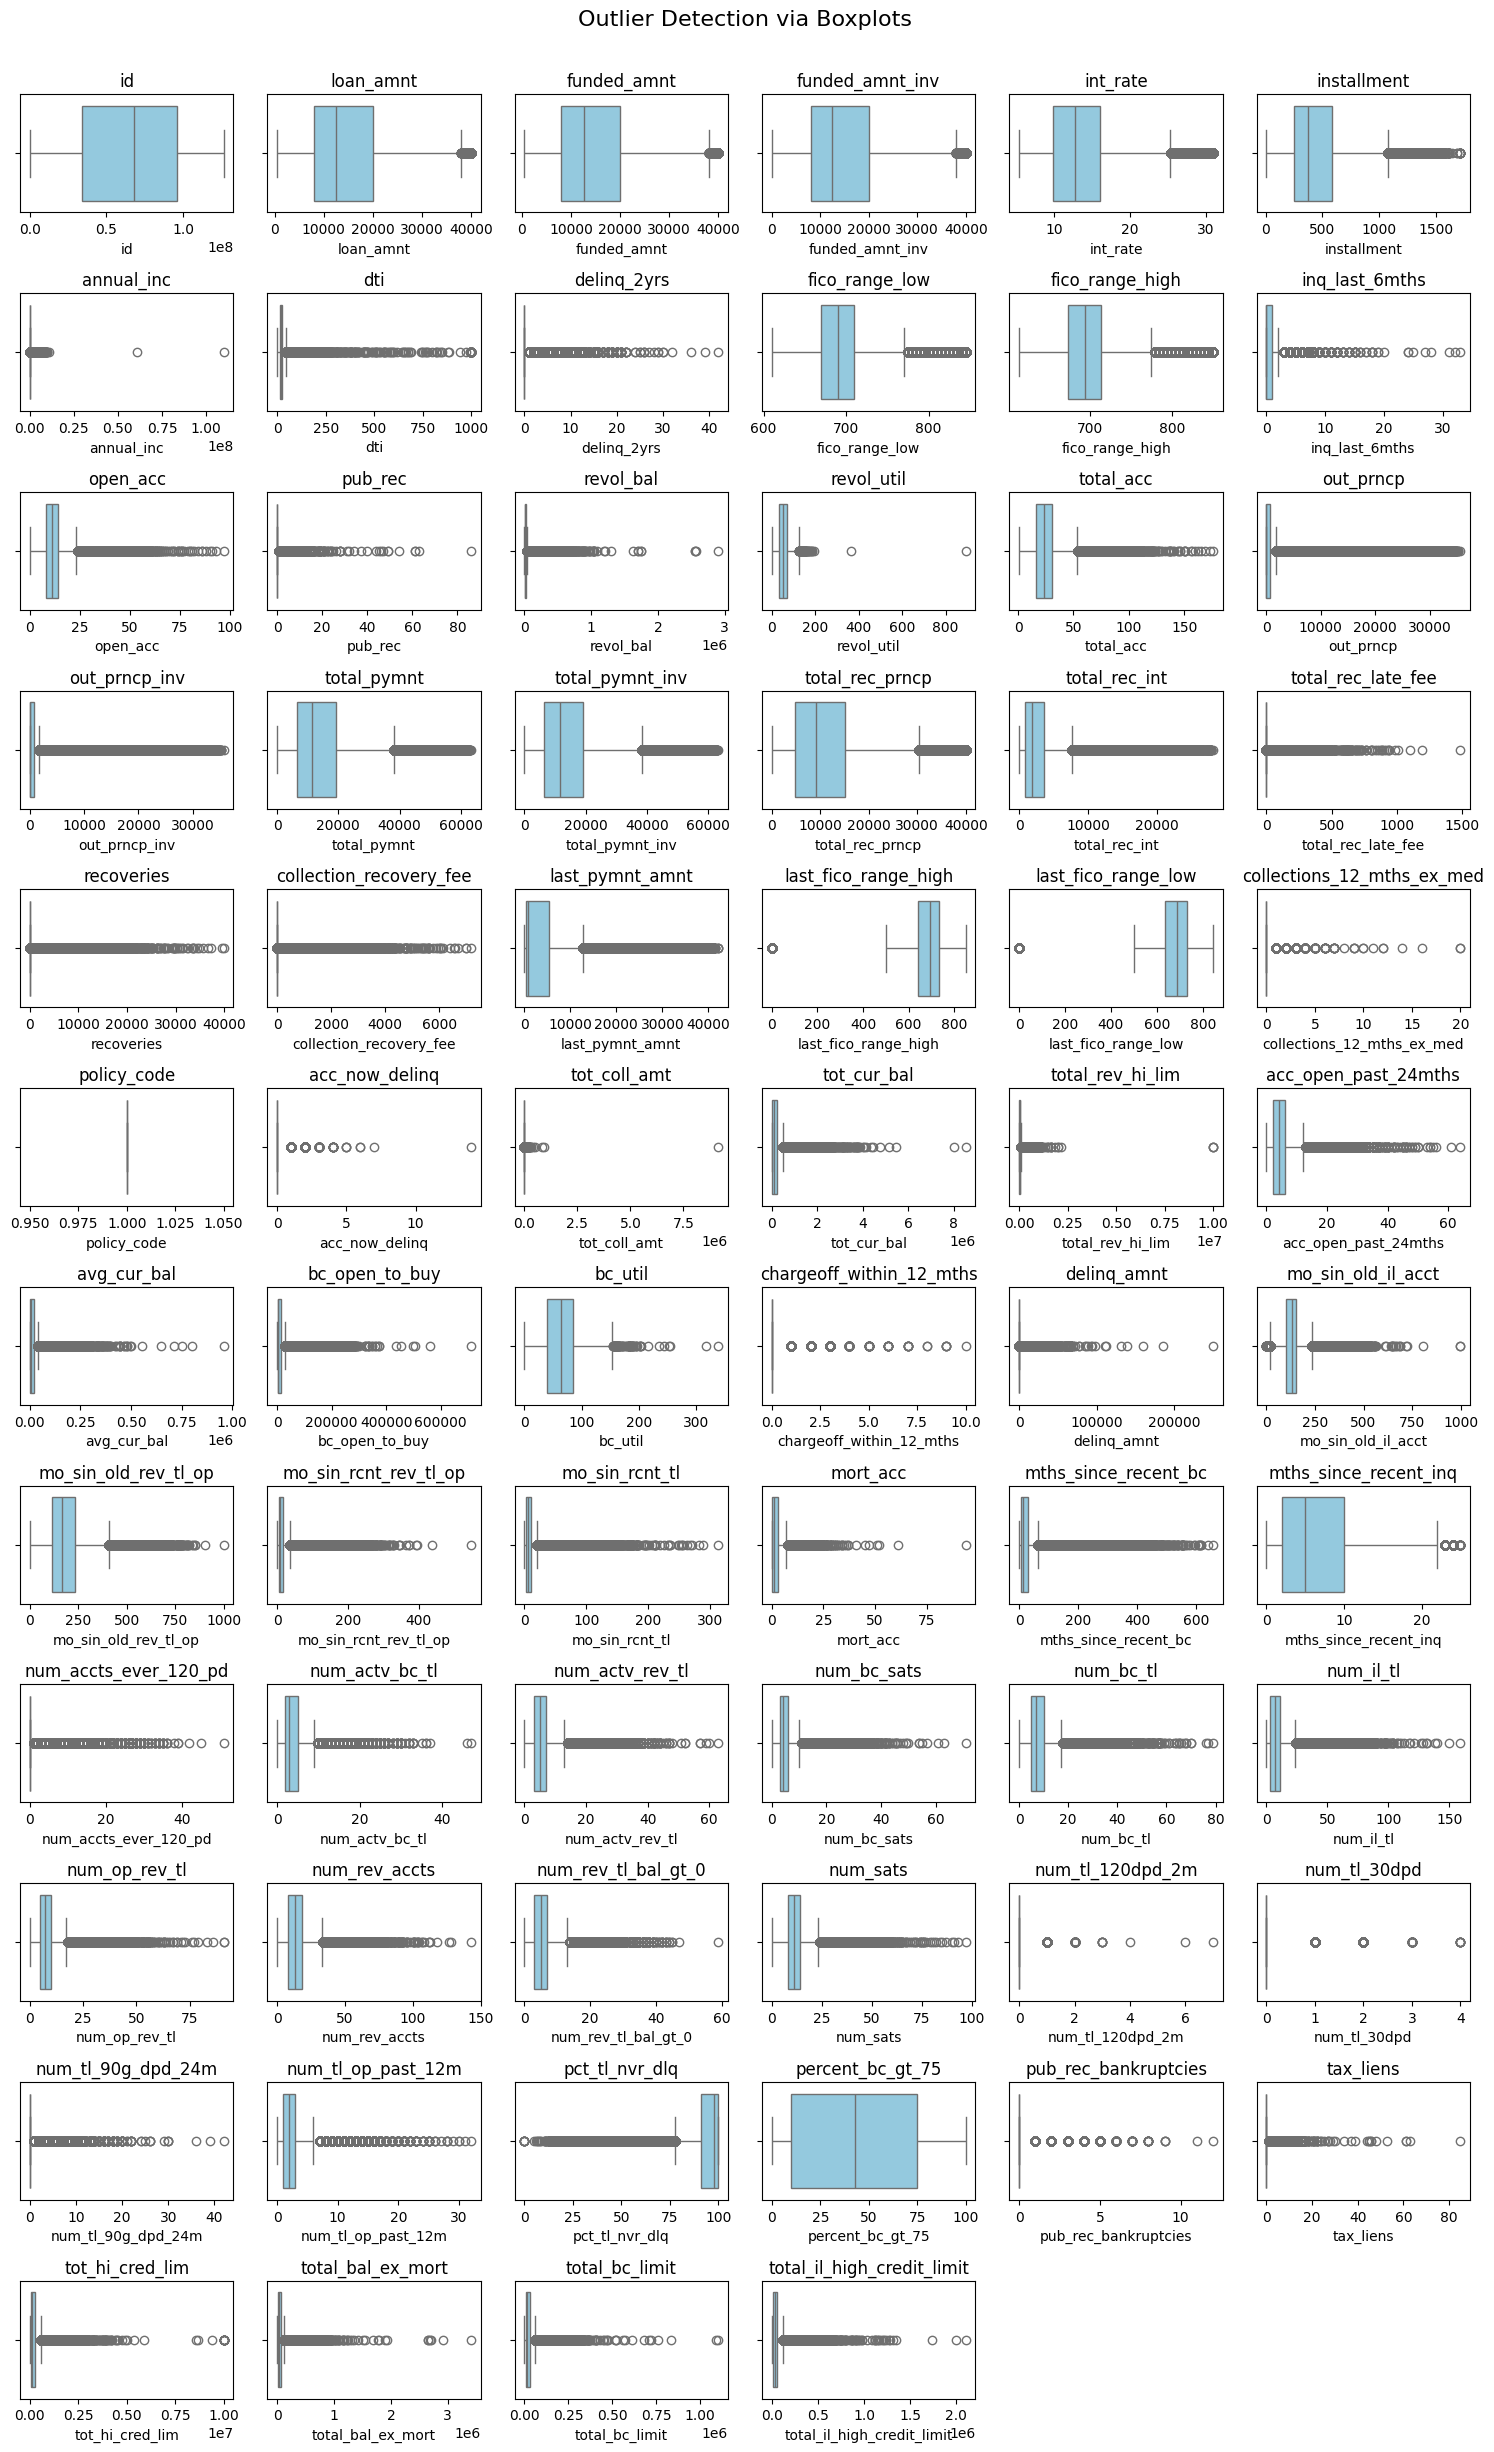

In [ ]:
def detect_outliers_iqr(df, multiplier=1.5):
    outliers = {}
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        outlier_rows = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if not outlier_rows.empty:
            outliers[col] = outlier_rows
    return outliers

def plot_outliers(df):
    numeric_cols = df.select_dtypes(include='number').columns
    num_cols = len(numeric_cols)
    ncols = 6
    nrows = (num_cols + ncols - 1) // ncols
    plt.figure(figsize=(2.5 * ncols, 2 * nrows))

    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(nrows, ncols, i)
        sns.boxplot(x=df[col], color='skyblue')
        plt.title(col)
        plt.tight_layout()

    plt.suptitle('Outlier Detection via Boxplots', fontsize=16, y=1.02)
    plt.show()

# Example usage:
# df = pd.read_csv("your_file.csv")
outliers_dict = detect_outliers_iqr(df)
plot_outliers(df)

# If you want to access outliers for a specific column:
# outliers_dict['annual_inc'] → DataFrame with outlier rows for that column

In [ ]:
# check for negative values
neg_features = (df[num_col] < 0).sum()[(df[num_col] < 0).sum() > 0]
df.loc[df[neg_features.index].lt(0).any(axis=1), neg_features.index]

,dti,total_rec_late_fee
296819,30.66,-7.000000e-10
360951,34.56,-5.000000e-10
521197,26.10,-1.800000e-09
557568,20.30,-5.100000e-09
746866,23.63,-9.500000e-09
875639,52.45,-2.000000e-10
964147,-1.00,0.000000e+00
987631,15.14,-3.900000e-09
1107166,18.38,-2.000000e-09
1382393,-1.00,0.000000e+00


- The outliers that can be treated at flag - high risk: revol_util, dti, bc_util, il_util, percent_bc_gt_75 are derived from devision formular, which are expected in the range of 0-1 or 0-100. if it's a positive outliers, this can indicate the financial stress of borrowers --> flag it later.

- Some extreme value can cause misleading outcome: annual income --> scale data
- Negative value like -1 dti can be an error

# Target analysis

In [ ]:
df[tar_col].value_counts().to_frame().reset_index()

,loan_status,count
0,Fully Paid,1029307
1,Current,451136
2,Charged Off,259692
3,Late (31-120 days),14246
4,In Grace Period,5517
5,Late (16-30 days),2746
6,Does not meet the credit policy. Status:Fully ...,1988
7,Does not meet the credit policy. Status:Charge...,761
8,Default,33


In [ ]:
label = df[tar_col].value_counts().index.values
bad_loan = label[[2, 3, 5, 6, 7, 8]]
df[tar_col] = df[tar_col].apply(lambda x: 1 if x in bad_loan else 0)

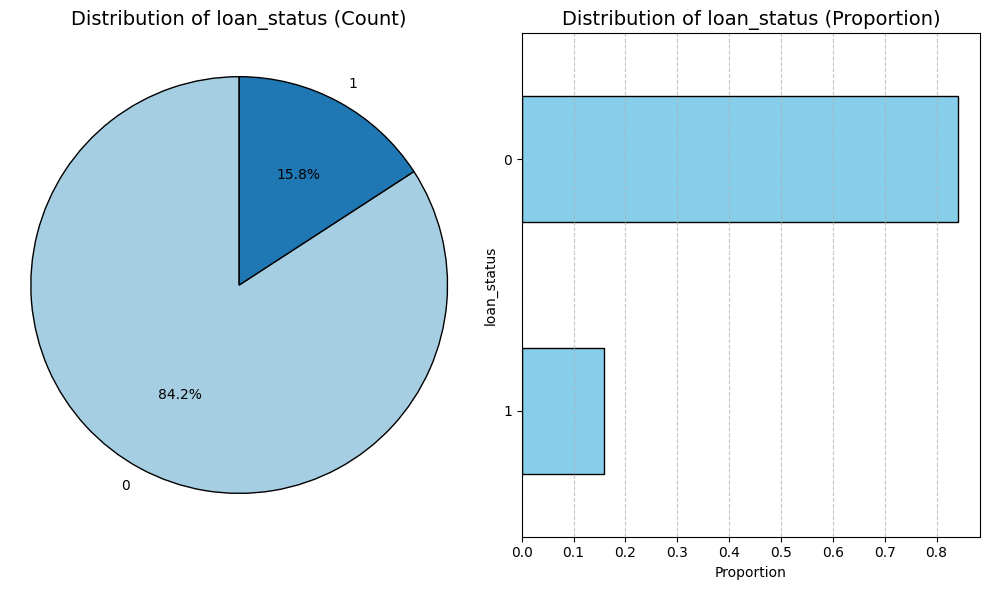

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))


# --- PIE CHART ---
df[tar_col].value_counts().plot(
    kind='pie',
    ax=axes[0],
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors,
    wedgeprops={'edgecolor': 'black'}
)
axes[0].set_ylabel('')
axes[0].set_title(f'Distribution of {tar_col} (Count)', fontsize=14)
axes[0].axis('equal')  # Keep it a circle

# --- BAR CHART ---
value_counts = df[tar_col].value_counts(normalize=True).sort_values()
value_counts.plot(
    kind='barh',
    ax=axes[1],
    color='skyblue',
    edgecolor='black'
)
axes[1].set_title(f'Distribution of {tar_col} (Proportion)', fontsize=14)
axes[1].set_xlabel('Proportion')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Numeric features

In [ ]:
desc = df[num_col].describe()

# Create a dictionary of formatters for numeric columns
formatters = {col: '{:.2f}'.format for col in desc.columns if pd.api.types.is_numeric_dtype(desc[col])}

# Use to_string with the formatters
print(desc.to_string(formatters=formatters))

                id  loan_amnt funded_amnt funded_amnt_inv   int_rate installment   annual_inc        dti delinq_2yrs fico_range_low fico_range_high inq_last_6mths   open_acc    pub_rec  revol_bal revol_util  total_acc  out_prncp out_prncp_inv total_pymnt total_pymnt_inv total_rec_prncp total_rec_int total_rec_late_fee recoveries collection_recovery_fee last_pymnt_amnt last_fico_range_high last_fico_range_low collections_12_mths_ex_med policy_code acc_now_delinq tot_coll_amt tot_cur_bal total_rev_hi_lim acc_open_past_24mths avg_cur_bal bc_open_to_buy    bc_util chargeoff_within_12_mths delinq_amnt mo_sin_old_il_acct mo_sin_old_rev_tl_op mo_sin_rcnt_rev_tl_op mo_sin_rcnt_tl   mort_acc mths_since_recent_bc mths_since_recent_inq num_accts_ever_120_pd num_actv_bc_tl num_actv_rev_tl num_bc_sats  num_bc_tl  num_il_tl num_op_rev_tl num_rev_accts num_rev_tl_bal_gt_0   num_sats num_tl_120dpd_2m num_tl_30dpd num_tl_90g_dpd_24m num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75 pub_rec_bankruptcie

## Annual income

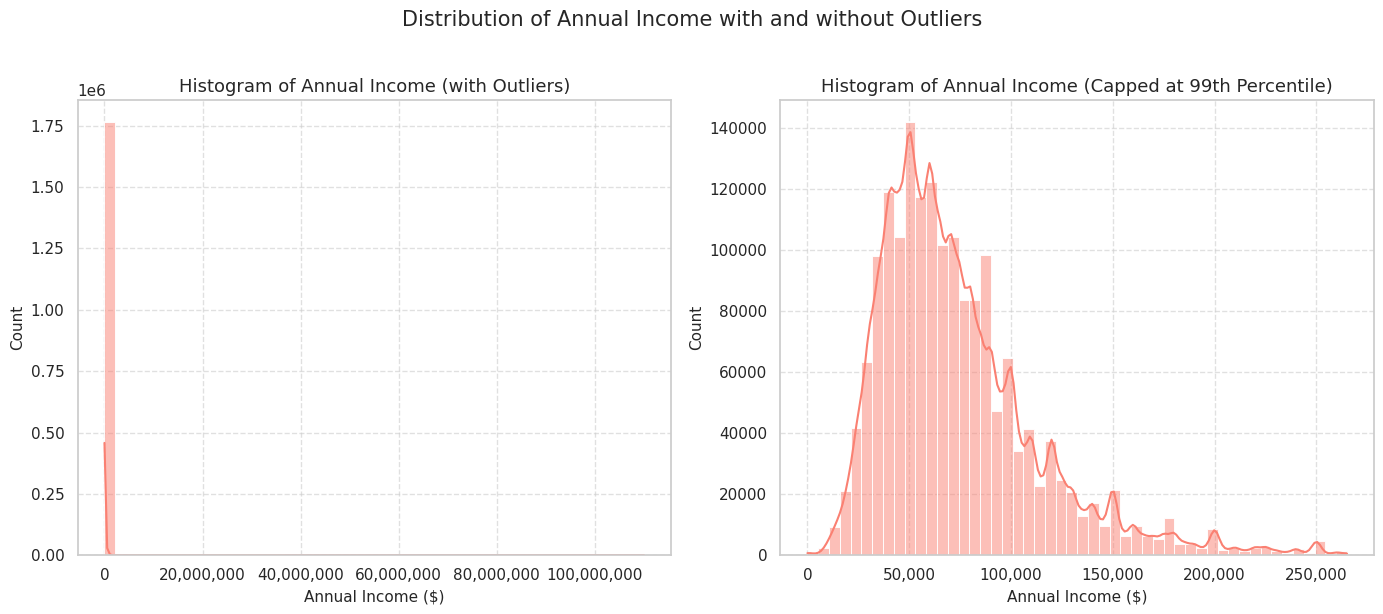

In [ ]:
import matplotlib.ticker as ticker
# Set style
sns.set(style="whitegrid")

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Threshold for outliers
threshold = df['annual_inc'].quantile(0.99)
filtered_df = df[df['annual_inc'] <= threshold]

# Plot with extreme values
sns.histplot(df['annual_inc'], bins=50, kde=True, ax=axes[0], color='salmon')
axes[0].set_title("Histogram of Annual Income (with Outliers)", fontsize=13)
axes[0].set_xlabel("Annual Income ($)", fontsize=11)
axes[0].set_ylabel("Count", fontsize=11)
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot without extreme values
sns.histplot(filtered_df['annual_inc'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Histogram of Annual Income (Capped at 99th Percentile)", fontsize=13)
axes[1].set_xlabel("Annual Income ($)", fontsize=11)
axes[1].set_ylabel("Count", fontsize=11)
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
axes[1].grid(True, linestyle='--', alpha=0.6)

# Final layout
plt.suptitle("Distribution of Annual Income with and without Outliers", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

- The histplot with and without extreme values show how the extreme values skew the distribution.
- Most customers are mass customers with income lower than 100000 USD.

# Multivariate analysis

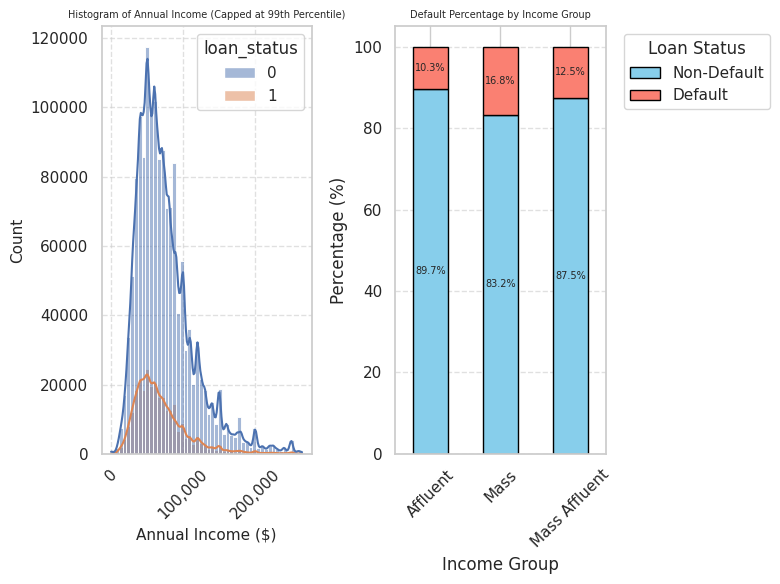

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(data=filtered_df, x='annual_inc', hue=tar_col, bins=50, kde=True, color='salmon', ax=axes[0])
axes[0].set_title("Histogram of Annual Income (Capped at 99th Percentile)", fontsize=7)
axes[0].set_xlabel("Annual Income ($)", fontsize=11)
axes[0].set_ylabel("Count", fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
axes[0].grid(True, linestyle='--', alpha=0.6)

def categorize_income(inc):
    if inc >= 250_000:
        return "Affluent"
    elif inc >= 100_000:
        return "Mass Affluent"
    else:
        return "Mass"
# Categorize income
df['income_group'] = df['annual_inc'].apply(categorize_income)

# Calculate default rate by group
# Assume loan_status column: 1 = default, 0 = non-default
grouped = df.groupby(['income_group', 'loan_status']).size().unstack(fill_value=0)

# Convert to percentage
percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot stacked bar
percent.plot(kind='bar', stacked=True, figsize=(8, 6),
                  color=['skyblue', 'salmon'], edgecolor='black', ax=axes[1])

# Formatting
axes[1].set_title("Default Percentage by Income Group", fontsize=7)
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].set_xlabel("Income Group", fontsize=12)
axes[1].legend(["Non-Default", "Default"], title="Loan Status", bbox_to_anchor=(1.05, 1))
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.1f%%", label_type="center", fontsize=7)

plt.tight_layout()
plt.show()




- As you can see in the histogram chart that the number of default by mass customer, and in the stack chart the ratio of default are higher compared to other.
- In the stack chart, we can see that the ratio of default in mass affluent is high. This can be caused that the number of mass affluent customers is low.

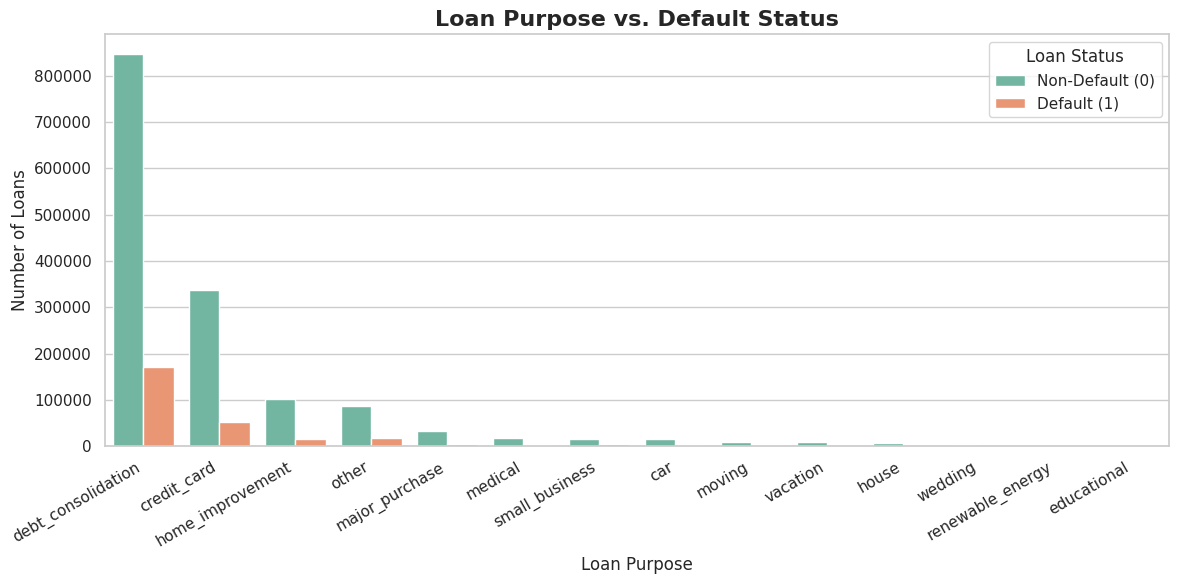

In [ ]:
# Set style
sns.set_theme(style="whitegrid")

# Countplot
plt.figure(figsize=(12,6))  # bigger figure
ax = sns.countplot(
    data=df,
    x='purpose',
    hue=tar_col,
    palette="Set2",   # nicer palette
    order=df['purpose'].value_counts().index  # sort by frequency
)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

# Titles and labels
ax.set_title("Loan Purpose vs. Default Status", fontsize=16, weight='bold')
ax.set_xlabel("Loan Purpose", fontsize=12)
ax.set_ylabel("Number of Loans", fontsize=12)

# Add legend with better title
ax.legend(title="Loan Status", labels=["Non-Default (0)", "Default (1)"])



plt.tight_layout()
plt.show()

- the majority of loan purpose is debt_consolidation and credit_card.
- debt_consolidation is mostly applied to reduce interest and simplify paid for people who already have multiple debts with high interest.
- Throught this chart, we can see the most customer are comsumption-driven borrowers (since lending club is a P2P lending, the service is almost for mass customers), not a investment-driven customer.

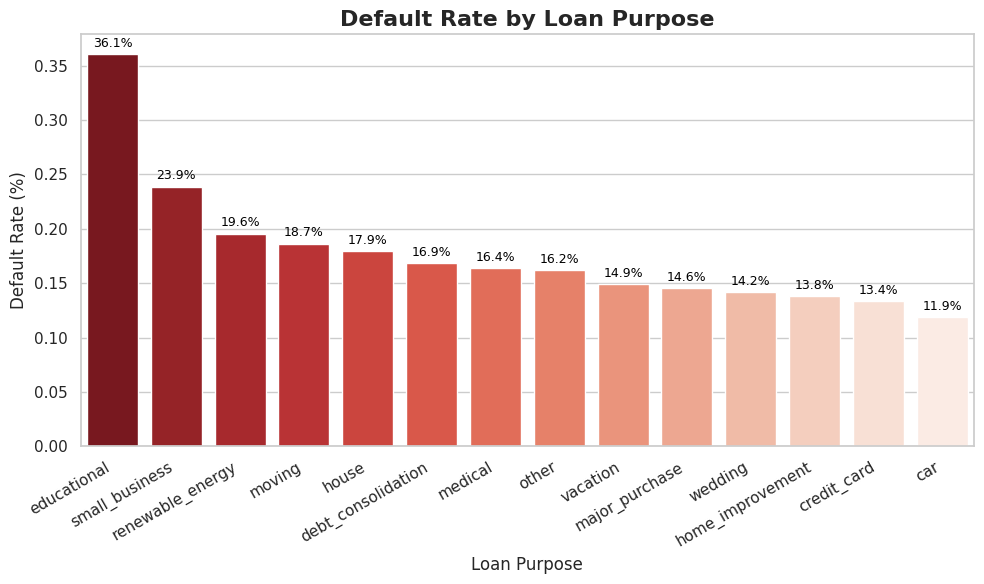

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate default rate per purpose
default_rate = (
    df.groupby("purpose")[tar_col]
      .mean()
      .reset_index()
      .sort_values(by=tar_col, ascending=False)
)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=default_rate,
    x="purpose",
    y=tar_col,
    palette="Reds_r"
)

# Titles and labels
ax.set_title("Default Rate by Loan Purpose", fontsize=16, weight="bold")
ax.set_xlabel("Loan Purpose", fontsize=12)
ax.set_ylabel("Default Rate (%)", fontsize=12)

# Rotate labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

# Annotate bars with percentages
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.1%}",
        (p.get_x() + p.get_width()/2., height),
        ha="center", va="bottom",
        fontsize=9, color="black",
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()


- The highly default rate is in educational, small_business and renewable_energy. This can be explained that this platform mainly serve for mass customer, so when an investment-drivent customer segment come in, it's not fit. This is because this segment need a larger and longterm-long with more flexible repayment. For example, in lending club, the borrower need to repay after maximum is 36 months, but what if the borrower is university student, they may need at least 4 years to earn money.

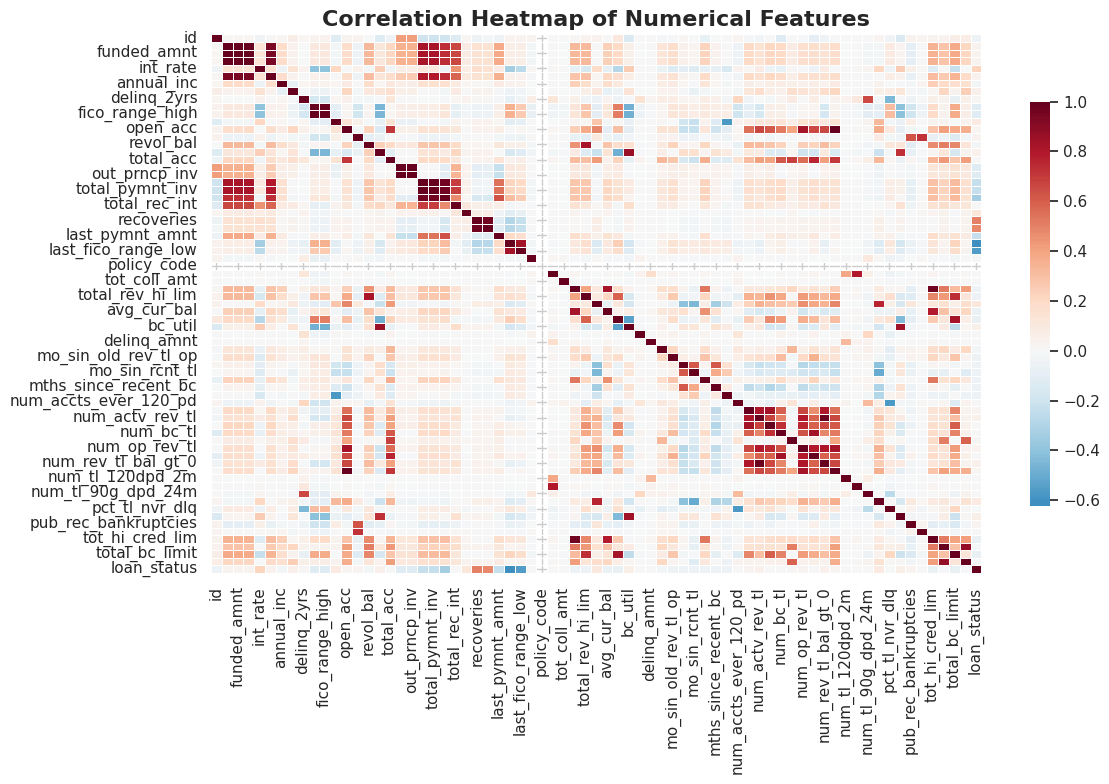

In [ ]:
corr = df[num_col + [tar_col]].corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    annot=False,       # set to True if you want the correlation values inside
    cmap="RdBu_r",     # nice diverging palette
    center=0,          # center the colormap at 0
    linewidths=0.5,
    cbar_kws={"shrink": .75}
)

plt.title("Correlation Heatmap of Numerical Features", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

In [ ]:
target_corr = corr[tar_col].sort_values(ascending=False)
print(target_corr)

loan_status                1.000000
recoveries                 0.500202
collection_recovery_fee    0.474824
int_rate                   0.225874
total_rec_late_fee         0.124622
                             ...   
last_pymnt_amnt           -0.239331
total_rec_prncp           -0.335150
last_fico_range_low       -0.558298
last_fico_range_high      -0.622249
policy_code                     NaN
Name: loan_status, Length: 71, dtype: float64


- The top features like recoveries or collection_recovery_fee is known after labeling phase so we need to remove it to avoid data leakage